<a href="https://colab.research.google.com/github/sarahkaarina/embedding_space/blob/main/embedding_space_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Computing narrative flow of information**

This notebook demonstrated how word embedding similarity observationally changes across layers in two language models, GPT2 and BERT.

*What do we mean by word embedding similarity?*

**STEP 1:** For each word in a given narrative, we can extract a token level embedding that is then mapped to the word from every layer of a given language model (i.e., GPT-2). This results in a list of word embeddings, arranged from the first word in the narrative to the last. With this arrangement, we can now evalute word by word similarity along the temporal dimension of the narrative. In generative models like GPT, word embeddings contain not only information relating to the word itself but also information related to the context preceeding the word. Therefore, similarity between word embeddings should be sensitive to how meaningful/linguistic information flows through a given narrative.

**STEP 2:** After extracting the word embeddings, from first to last, we can then compute cosine similarity between each of these word embeddings. This results in a word by word symmetric matrix containing the cosine similarity values, where the diagonal only contains values of 1 (perfect cosine similarity).

**STEP 3:** We can then take the lower triangle of the word embedding matrix to get a 1-D vector that represents the distribution of word-by-word similarity values. Rounding these values to the first decimal place, gives us a discrete probability distribution of values -1 =< x =< 1. Using Shannon's entropy (below), we can use this probability distribution to estimate the noise in the signal, that is with what certainty words are completely similar or dissimilar to one another. We expect that in a given narrative, similarity distributions that contain word-level feature information should be very 'noisy' with a blend of words that are similar/dissimilar to each other on the basis of semantic content/syntatic features/distance apart. Instances where the model embedding space starts to converge onto higher level meanings should result in lower entropy values, such as in the upper layers of GPT-2 where we see anisotropic distributions of the embedding space, than when the embedding space is more isotropically distributed.

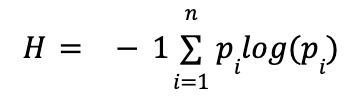



**Demo**

To demonstrate how word embeddings relate to each other across a given contextual window and to show how entropy changes as a function of layers for the two models used in our paper (GPT-2 and BERT), I will load a dataset containing the plot summaries of movies from the HuggingFace datasets library.

After computing entropy, I will plot the entropy values for every example narrative across the layers of these two models.

Additionally, I will plot the similarity matrix itself, where I can examine how word embedding similarity is distributed for every layer in three examples narrative, and the t-SNE clustering results on two-dimensions for 10 example narratives. I will do this separately for each model.

Data reference: https://huggingface.co/datasets/vishnupriyavr/wiki-movie-plots-with-summaries


In [ ]:
!pip install --upgrade datasets fsspec --quiet

In [ ]:
# datasets gave me a bunch of problems if I only installed !pip install datasets without upgrading my fsspec
# infatti, you'll still see a bunch of error messages when you run the above cell
# I ASSUME (assume) this is related to me using datasets in collab - if you test this code out yourself on a local machine
# PLEASE CHECK THAT RUNNING UPGRADING FFSPEC DOESN'T MESS WITH YOUR LOCAL DEPENDENCIES
#
# Adding trust_remote_code=True allows for datasets to be imported in collab
# not adding again generates some errors AGAIN assumptively from using collab and not a local machine
# Therefore:
# --upgrade datasets ffspec
# trust_remote_code=True
# Most likely depend on this script running in Collab and should be revaluted before being run on something local/not Collab

from datasets import load_dataset
import random
random.seed(999)

ds = load_dataset("vishnupriyavr/wiki-movie-plots-with-summaries", trust_remote_code=True)

In [ ]:
plot_summaries = ds["train"]["Plot"]

In [ ]:
import string

# Create a translator (kind of like regex in R)
# where we will remove all punctuation EXCEPT for apostrophes!
# WHY? Without apostrophes, the GPT tokenizer (later on) will not understand
# to embed pronous + auxiliaries
# NB: FOR THIS ANALYSIS, I won't remove punctation because we are dealing with WRITTEN not ORAL text.
# Therefore, punctuation is important as de-marks something about the organization of written data.
# If I were working with transcribed oral language, I would remove punctuation as now punctuation becomes artefactual
# interpreation on the part of the transcriber (may this be Open AI's Whisper or a real human) of how utterances are
# constructed into written speech
# (TLDR; full stops don't mean much for how information is used in spoken language, they just make it legible.).

punctuation_except_apostrophe = string.punctuation.replace("'", "")
remove_punctuation = str.maketrans('', '', punctuation_except_apostrophe)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# library for removing substrings
import re

import math

#libraries for calculating similarity
#if you need to install sklearn as a module, it will only work if you install as scikit-learn
#however, will still let you import through sklearn module

from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

# import your PRETRAINED OFFLINE MODELS
# I will specify this in all caps - why?
# From my understanding, data that is under non-commerical use license (i.e., most research data, even open source stuff)
# cannot be passed to a language model that actively stores, fine-tunes, or trains on that data.
# THEREFORE IF YOUR DATA IS UNDER NON-COMMERICAL USE
# The most appropriate way (as I understood it) is to download the weights and tokenizers from pre-trained models using the transformers library
# As long as the models are used offline (and you are respecting any data usage agreement), i.e., you are not interfacing with an API/commercial entity you can fine-tune, embed, etc. to your heart's
# content on data restricted by non-commerical use licensing.
# THIS IS MY UNDERSTANDING (I repeat)
# If what I said sounds like complete bolony please feel free to tell me otherwise by raising an issue to this repo's git hub page
# or stalking me online and finding my most current institutional email
from transformers import GPT2Tokenizer, GPT2Model, BertTokenizer, BertModel

import torch
# Fun hack, if you have a Mac with an MP processor (not an Intel one) you can probably run this locally on the MP's GPU
# But because it's a mac torch won't find a CUDA GPU but instead needs to look for an MPS one
# have fun on my behalf (I still haven't upgraded my mac to the silicone processor): https://developer.apple.com/metal/pytorch/
# NB: if like me you only have local CPUs this code will still run (as it will default to CPU)
# BUT you may need to fix a few lines further down as when the tensor items are returned to the CPU they need to be converted from GPU readable
# to cpu readable.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set the device globally
torch.set_default_device(device)

# import Spacy tokenizer
#
# Spacy is an NLP tools that will tag parts of speech, so tokenizes at a word and morpheme level
# (i.e., I [pronoun] am [auxiliary] and I [pronoun]'m [auxiliary])
# Spacy is trained specific to language, that is, while a LLM tokenizer simply cares about frequently occurent 'bits'
# Spacy wants to look for parts of language that confirm with predetermined notions of word-class/syntactic rules
# for reference: https://spacy.io/api/tokenizer
# I would also reccomend this lecture, for a breakdown of how LLM (i.e. BPE tokenizers) work: https://www.youtube.com/watch?v=9vM4p9NN0Ts&t=541s
#
# NB. I am not an NLP person, but I wanted to flag this difference because when you have typos (as may happen in transcript/medical record data)
# the Spacy tokenizer is clever in that if it can identify something that looks like a pronoun ('Im' written instead of 'I'm) it will still tag
# I [pronoun] and m [auxiliary] correctly. A BPE (like the one used by GPT) will not, I will see 'Im' as one token.
# Indeed, this won't be the case for the data in this notebook but if you part of speech tag real data (with typos) and then try to line it up with token
# level distinctions in GPT2, the two may not line up.
#
# Just something to consider.

import spacy

# what you need to download the images from this notebook
# NB: I will leave the downloading lines of code commented out so that if you run it your downloads folder won't clog up with stuff.
# Uncomment to download said images.
from google.colab import files

import random


In [ ]:
def count_words(narrative):
    spaces = narrative.count(' ')
    tabs = narrative.count('\t')
    newlines = narrative.count('\n')
    words = spaces+tabs+newlines+1
    return words

In [ ]:
def compute_word_embedding(sentences2embed, lm_model: str):

    if lm_model =='gpt':
        model_name = 'gpt2'
        tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        model = GPT2Model.from_pretrained(model_name)

    elif lm_model =='bert':
        tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-cased")
        model = BertModel.from_pretrained("google-bert/bert-base-cased")

    # Run model on GPU
    model = model.to(device)
    sentences2embed = str(sentences2embed)

    # Tokenize and pad sequences
    encoded_sentences = tokenizer(
                  sentences2embed,
                  return_tensors='pt')

    inputs = encoded_sentences['input_ids']

    with torch.no_grad():
        outputs = model(inputs.to(device), output_hidden_states=True)
    hidden_states = outputs.hidden_states

    return hidden_states

def tag_words(sentences2embed):

    # load parts of speech tagger
    nlp = spacy.load('en_core_web_sm')

    doc = nlp(sentences2embed)
    word_classes = [(token.text, token.pos_) for token in doc]
    return word_classes

def grab_embeddings_by_layer(hidden_states, layer, word_classes):
    layer = int(layer)
    layer_embeddings = hidden_states[layer]
    embeddings = layer_embeddings.squeeze()

    # Combine embeddings with word classes
    indexed_embeddings = {}
    for i, (pos) in enumerate(word_classes):
      indexed_embeddings[i] = {'embedding': embeddings[i], 'word_class': pos}

    return indexed_embeddings


In [ ]:
def grab_list2use(word_metric):
    if metric == "content":
        list2use = ['ADJ', 'ADV', 'INTJ', 'NOUN', 'PROPN']
    elif metric == "function":
        list2use = ['CONJ', 'CCONJ', 'DET', 'NUM', 'PART', 'PRON', 'SCONJ', 'ADP']
    elif metric == "predicate":
        list2use = ['AUX', 'VERB']
    elif metric == "all":
        list2use = ['ADJ', 'ADV', 'INTJ', 'NOUN', 'PROPN', 'CONJ', 'CCONJ', 'DET', 'NUM', 'PART', 'PRON', 'SCONJ', 'ADP', 'AUX', 'VERB']
    return list2use

In [ ]:
def similarity_by_word_class(combined_embeddings, word_metric, sim_metric):

    list2use = grab_list2use(word_metric)
    # Use only metric of interest
    filtered_embeddings = [item['embedding'].cpu().numpy() for item in combined_embeddings if item['word_class'][1] in list2use]
    #print(f"Metric {metric}: {len(filtered_embeddings)}")

    similarity_embeddings = np.around(1-pairwise_distances(filtered_embeddings, filtered_embeddings, metric=sim_metric), 1)

    lower_triangle = np.tril(similarity_embeddings)

    similarity_vector = list(lower_triangle[np.tril_indices_from(lower_triangle)])

    return similarity_embeddings, similarity_vector


In [ ]:
def compute_similarity_entropy(similarity_vector):

    # higher entropy represents more diversity of context
    # computed as a function of n of instances of similarity values distributed between -1 and 1
    # where 1 is complete similarity (0 degrees) and 0 non similarity (90 degrees), and -1 is complete dissimilarity (180 degrees)
    # we will round to the 1st decimal so we can only have instances of 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1

    length_of_vector = len(similarity_vector)

    # get median of distribution
    median_similarity = np.median(similarity_vector)

    # get standard deviation
    std_similarity = np.std(similarity_vector)

    # create empty dict
    counts = {value: 0 for value in similarity_vector}

    # count number of instances of values 0 to 10 in the similarity vector
    for value in similarity_vector: #sim_vector_by10:
        if value in counts:
            counts[value] += 1

    # compute probabilities for each instance in your given similarity vector (p(i) = count_i/n) where n is the total number of similarity comparisons
    # we get the n from the length of the similarity vector
    probabilities = {}

    for value, count in counts.items():
        probabilities[value] = count/length_of_vector

    entropy_probabilities = {}

    for value, probability in probabilities.items():
        if probability == 0:
            entropy_probabilities[value] = 0
        else:
            entropy_probabilities[value] = -1*(math.log(probability)*probability)

    final_values_to_compute_entropy_on = list(entropy_probabilities.values())

    entropy_value = sum(final_values_to_compute_entropy_on)

    return entropy_value, median_similarity, std_similarity

Run analysis

In [ ]:
narrative_df = pd.DataFrame({ "narratives_clean" : None,
                            "word_count" : None},
                            index=range(len(plot_summaries)))


for i in range(len(plot_summaries)):
  word_count = count_words(plot_summaries[i])
  narrative_df.loc[i, 'narratives_clean'] = plot_summaries[i]
  narrative_df.loc[i, 'word_count'] = word_count

In [ ]:
# subset df for word counts to be within token window (< 512 since we're comparing with BERT, even though GPT can take up to 1024)
# ~750 words = 1000 tokens (ref: https://news.ycombinator.com/item?id=35841781)

narrative_df = narrative_df[narrative_df["word_count"].between(100, 300)]
len(narrative_df)

In [ ]:
narrative_sampled_df = narrative_df.sample(n=300, random_state = 999)

In [ ]:
narrative_sampled_df.head()

In [ ]:
sim_metric = "cosine"
metric = "all"
lm_model = "gpt"

# Initialize lists to store per-narrative results
gpt_entropy = []
gpt_median = []
gpt_std = []
gpt_count = []
gpt_sim = []

combined_embeddings = []
layer_labels = []

for i in range(len(narrative_sampled_df)):

    shannon_entropy_row = {}
    count_row = {}
    sim_row = {}
    median_similarity_dist = {}
    std_similarity_dist = {}

    # grab narrative you want to use and its respective word count
    narrative = narrative_sampled_df['narratives_clean'].iat[i]
    word_count = narrative_sampled_df['word_count'].iat[i]

    # grab word embeddings for every word in the narrative, for every layer
    all_layer_embeddings = compute_word_embedding(narrative, lm_model)

    # tag each word with it's respective word class (based on the Space tokenizer)
    word_classes = tag_words(narrative)

    # loop across input + 12 (13) layers of the model and store each embedding
    # compute similarity between each word embedding for each layer
    # compute entropy on the resulting word level similarity distribution

    for layer_index in range(13):
        layername = f'layer_{layer_index}'
        column_name = f'entropy_{layername}'

        # grab the embeddings for the needed layer
        embeddings = grab_embeddings_by_layer(all_layer_embeddings, layer_index, word_classes)

        # store out embeddings for later t-SNE plots (layer_labels also stores which layer these embeddings correspond to)
        combined_embeddings.append(embeddings)
        layer_labels.extend([layer_index] * len(embeddings))

        # compute similarity on each word embedding, word by word
        # before we do that we need to pass the embeddings as a list
        embed_list = list(embeddings.values())
        similarity_df, similarity_vector = similarity_by_word_class(embed_list, metric, sim_metric)

        # save out our word x word similairty matrix for latter plotting
        sim_row[layername] = similarity_df


        # on the lower triangle of the similarity distribution, compute shannon's entropy
        # also store out the median and the standard deviation of the distribution
        shannon, median, std = compute_similarity_entropy(similarity_vector)
        shannon_entropy_row[column_name] = shannon
        median_similarity_dist[column_name] = median
        std_similarity_dist[column_name] = std

        # store out how many unmique instances they were of each similarity value in the vector
        # for if we want to plot the distribution later on
        unique, counts = np.unique(similarity_vector, return_counts=True)
        count_row[layername] = dict(zip(unique, counts))

    # append per-narrative results
    gpt_entropy.append(shannon_entropy_row)
    gpt_median.append(median_similarity_dist)
    gpt_std.append(std_similarity_dist)
    gpt_count.append(count_row)
    gpt_sim.append(sim_row)


gpt_entropy_df = pd.DataFrame(gpt_entropy)
gpt_median_df = pd.DataFrame(gpt_median)
gpt_std_df = pd.DataFrame(gpt_std)


In [ ]:
for i in range(len(gpt_entropy_df)):
    plt.plot(range(gpt_entropy_df.shape[1]), gpt_entropy_df.iloc[i])

plt.xlabel('Model Layers')
plt.ylabel('Entropy')
plt.title("Shannon's entropy as it changes over layers of the GPT model")

# save out
# plt.savefig("gpt_entropy.png", dpi = 600)
# files.download("gpt_entropy.png")

plt.show()

In [ ]:
for i in range(len(gpt_median_df)):
    plt.plot(range(gpt_median_df.shape[1]), gpt_median_df.iloc[i])

plt.xlabel('Model Layers')
plt.ylabel('Median')
plt.title("Median of the similarity distribution as it changes over layers of the GPT model")

# save out
# plt.savefig("gpt_median.png", dpi = 600)
# files.download("gpt_median.png")

plt.show()

In [ ]:
for i in range(len(gpt_std_df)):
    plt.plot(range(gpt_std_df.shape[1]), gpt_std_df.iloc[i])

plt.xlabel('Model Layers')
plt.ylabel('Standard Deviation')
plt.title("Standard deviation of the similarity distribution as it changes over layers of the GPT model")

# save out
# plt.savefig("gpt_std.png", dpi = 600)
# files.download("gpt_std.png")

plt.show()

In [ ]:
n_layers = 13
n_cols = 4
n_rows = (n_layers + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
axes = axes.flatten()

for layer_index in range(n_layers):
    #plt.figure()  # create a new figure for each layer
    ax = axes[layer_index]

    layername = f'layer_{layer_index}'

    for i in range(len(gpt_count)):
      #ax = axes[layer_index, layer_index]
      ax.plot(
            list(gpt_count[i][layername].keys()),
            list(gpt_count[i][layername].values())#,
            #marker='D'
        )
      ax.set_xlabel('Similarity Value')
      ax.set_ylabel('Count')
      ax.set_title(f'Layer {layer_index}')

for j in range(n_layers, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# save out
# plt.savefig("gpt_density.png", dpi = 600)
# files.download("gpt_density.png")

plt.show()

In [ ]:
# https://matplotlib.org/stable/gallery/color/named_colors.html
from sklearn.metrics import r2_score # https://data36.com/linear-regression-in-python-numpy-polyfit/

n_layers = 13
n_cols = 4
n_rows = (n_layers + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
axes = axes.flatten()

for layer_index in range(n_layers):

    layername = f'layer_{layer_index}'
    column_name = f'entropy_{layername}'

    ax = axes[layer_index]

    layername = f'layer_{layer_index}'

    x = np.array(narrative_sampled_df['word_count']).astype(float)
    y = np.array(gpt_entropy_df[column_name]).astype(float)

    # get quantile value
    # y_quantile = np.quantile(y, 0.75)
    max_val = max(y) - 0.04

    # create line of best fit us np.ployfit
    # https://www.statology.org/line-of-best-fit-python/

    a, b = np.polyfit(x, y, 1)
    y_pred = a * x + b
    r2 = np.round(r2_score(y, y_pred), 2)
    ax.scatter(x, y, color = 'plum')
    ax.plot(x, a*x+b, color = 'indigo')
    ax.text(x[10], max_val, f"r = {r2}", size=12)

    ax.set_xlabel('Word count')
    ax.set_ylabel('Entropy')
    ax.set_title(f'Layer {layer_index}')

for j in range(n_layers, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# save out
# plt.savefig("gpt_word2entropy.png", dpi = 600)
# files.download("gpt_word2entropy.png")

plt.show()

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
# https://distill.pub/2016/misread-tsne/
# NB: t-SNE embeddings try to find clustering patterns
# Why not UMAP? https://datascience.stackexchange.com/questions/121310/dimension-reduction-of-word-embeddings-pca-vs-tsne
# https://www.datacamp.com/tutorial/introduction-t-sne
#
#
# Plot embeddings of example narrative 1

# index = 1

for index in range(10):

  tsne = TSNE(n_components=2, random_state=999)

  gpt_combined_embeddings = []
  gpt_layer_labels = []

  narrative = narrative_sampled_df['narratives_clean'].iat[index]

  all_layer_embeddings = compute_word_embedding(narrative, 'gpt')
  word_classes = tag_words(narrative)

  list2use = grab_list2use("all")

  for layer_index in range(13):
    embeddings = grab_embeddings_by_layer(all_layer_embeddings, layer_index, word_classes)
    embed_list = list(embeddings.values())
    filtered_embeddings = [item['embedding'].cpu().numpy() for item in embed_list if item['word_class'][1] in list2use]

    for _ in filtered_embeddings:
        gpt_layer_labels.append(layer_index)

    gpt_combined_embeddings.append(filtered_embeddings)

  # Combine all embeddings into a single array
  gpt_combined_embeddings = np.vstack(gpt_combined_embeddings)

  # Fit and transform the combined embeddings
  embeddings_2d = tsne.fit_transform(gpt_combined_embeddings)

  plt.figure(figsize=(10, 8))
  scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=gpt_layer_labels, cmap='tab20b')

  legend1 = plt.legend(*scatter.legend_elements(), title="Layers")
  plt.gca().add_artist(legend1)

  narrative_num = index + 1
  plt.title(f"GPT word embeddings from Narrative {narrative_num}")
  plt.xlabel('First Dimension (t-SNE)')
  plt.ylabel('Second Dimension (t-SNE)')

  # save out
  # plt.savefig(f"tsne_{index}.png", dpi = 600)
  # files.download(f"tsne_{index}.png")

  plt.show()


In [ ]:
plot_1 = gpt_sim[0]
words = narrative_sampled_df['narratives_clean'].iat[0].split()
for layer_index in range(6):
    layername = f'layer_{layer_index}'
    similarity_embeddings = plot_1[layername] # Get the similarity matrix for the current layer

    plt.figure(figsize=(8, 6)) # Create a new figure for each heatmap

    sns.heatmap(similarity_embeddings,
                annot=False,
                cmap="mako",
                yticklabels=False,
                xticklabels=False)
    #plt.axis('square')
    plt.title(f"Layer {layer_index} Similarity Matrix")
    # save out
    # plt.savefig(f"similarity_{layer_index}_0.png", dpi = 600)
    # files.download(f"similarity_{layer_index}_0.png")

    plt.show()

In [ ]:
plot_1 = gpt_sim[0]
words = narrative_sampled_df['narratives_clean'].iat[0].split()
for layer_index in range(6, 13):
    layername = f'layer_{layer_index}'
    similarity_embeddings = plot_1[layername] # Get the similarity matrix for the current layer

    plt.figure(figsize=(8, 6)) # Create a new figure for each heatmap

    sns.heatmap(similarity_embeddings,
                annot=False,
                cmap="mako",
                yticklabels=False,
                xticklabels=False)
    #plt.axis('square')
    plt.title(f"Layer {layer_index} Similarity Matrix")
    # save out
    # plt.savefig(f"similarity_{layer_index}_0.png", dpi = 600)
    # files.download(f"similarity_{layer_index}_0.png")

    plt.show()

In [ ]:
# find 'elbow' words in layer 12

words = tag_words(str(narrative_sampled_df['narratives_clean'].iat[0]))
list2use = grab_list2use("all")

words2check = []
for word in words:
  if word[1] in list2use:
    words2check.append(word[0])

layer_12_similarity = plot_1['layer_12']
elbow_indices = []
for row in range(len(layer_12_similarity)):
  if sum(layer_12_similarity[row]) < 0:
    elbow_indices.append(row)

if len(words2check) == len(layer_12_similarity):
  for index in elbow_indices:
    print(f"{words2check[index]} at index {index}")

In [ ]:
plot_1 = gpt_sim[1]
words = narrative_sampled_df['narratives_clean'].iat[1].split()
for layer_index in range(6):
    layername = f'layer_{layer_index}'
    similarity_embeddings = plot_1[layername] # Get the similarity matrix for the current layer

    plt.figure(figsize=(8, 6)) # Create a new figure for each heatmap

    sns.heatmap(similarity_embeddings,
                annot=False,
                cmap="mako",
                yticklabels=False,
                xticklabels=False)
    #plt.axis('square')
    plt.title(f"Layer {layer_index} Similarity Matrix")
    # save out
    # plt.savefig(f"similarity_{layer_index}_1.png", dpi = 600)
    # files.download(f"similarity_{layer_index}_1.png")

    plt.show()

In [ ]:
plot_1 = gpt_sim[1]
words = narrative_sampled_df['narratives_clean'].iat[1].split()
for layer_index in range(6, 13):
    layername = f'layer_{layer_index}'
    similarity_embeddings = plot_1[layername] # Get the similarity matrix for the current layer

    plt.figure(figsize=(8, 6)) # Create a new figure for each heatmap

    sns.heatmap(similarity_embeddings,
                annot=False,
                cmap="mako",
                yticklabels=False,
                xticklabels=False)
    #plt.axis('square')
    plt.title(f"Layer {layer_index} Similarity Matrix")
    # save out
    # plt.savefig(f"similarity_{layer_index}_1.png", dpi = 600)
    # files.download(f"similarity_{layer_index}_1.png")

    plt.show()

In [ ]:
plot_1 = gpt_sim[2]
words = narrative_sampled_df['narratives_clean'].iat[2].split()
for layer_index in range(6):
    layername = f'layer_{layer_index}'
    similarity_embeddings = plot_1[layername] # Get the similarity matrix for the current layer

    plt.figure(figsize=(8, 6)) # Create a new figure for each heatmap

    sns.heatmap(similarity_embeddings,
                annot=False,
                cmap="mako",
                yticklabels=False,
                xticklabels=False)
    #plt.axis('square')
    plt.title(f"Layer {layer_index} Similarity Matrix")
    # save out
    # plt.savefig(f"similarity_{layer_index}_2.png", dpi = 600)
    # files.download(f"similarity_{layer_index}_2.png")

    plt.show()

In [ ]:
plot_1 = gpt_sim[2]
words = narrative_sampled_df['narratives_clean'].iat[2].split()
for layer_index in range(6, 13):
    layername = f'layer_{layer_index}'
    similarity_embeddings = plot_1[layername] # Get the similarity matrix for the current layer

    plt.figure(figsize=(8, 6)) # Create a new figure for each heatmap

    sns.heatmap(similarity_embeddings,
                annot=False,
                cmap="mako",
                yticklabels=False,
                xticklabels=False)
    #plt.axis('square')
    plt.title(f"Layer {layer_index} Similarity Matrix")
    # save out
    # plt.savefig(f"similarity_{layer_index}_2.png", dpi = 600)
    # files.download(f"similarity_{layer_index}_2.png")

    plt.show()

**Anistropy and its relationship to interpretable meaning: "signal words"**

By looking at word by word embedding cosine similarity GPT's layers, and interesting patter emerges. In the last layer of the model, the majority of words reach almsot perfect cosine similarity (in line with previous findings of the embedding space becoming increasingly anistropic).

If it were the case that this is simply an afterfact of all the words all now representing some kind of 'global' meaning related to the given context window (in this case our narrative), then why do we see these 'grids' form of single words that suddenly have perfect cosine dissimilarity (180 degrees of angle)?

NB: Note that this is the only layer for which we see negative values in the similarity distribution.

I term them 'signal' words, in that it is possible they containing signalling information to the model as moves from embedding to embedding (or they may just be noise, but the fact it's a repeated patters that occurs suggests otherwise). To examine if there are any co-occuring patterns regarding these 'elbow' words, I will count for each narrative the word class that these words belong to.

We will see below, that the majority of them belong to noun and verb classes.

In [ ]:
# find 'signal' words in layer 12

all_counts = []
list2use = grab_list2use("all")

for index in range(len(narrative_sampled_df)):
  words2check = []
  plots = gpt_sim[index]
  words = tag_words(str(narrative_sampled_df['narratives_clean'].iat[index]))
  pos_counts = {tag: 0 for tag in list2use}

  words2check = []
  for word in words:
    if word[1] in list2use:
      words2check.append(word[1])

  layer_12_similarity = plots['layer_12']
  elbow_indices = []
  for row in range(len(layer_12_similarity)):
    if sum(layer_12_similarity[row]) < 0:
      value = words2check[row]
      if value in list2use:
          pos_counts[value] += 1
  all_counts.append(pos_counts)

In [ ]:
total_counts = {tag: 0 for tag in list2use}

for counts_dict in all_counts:
    for pos, count in counts_dict.items():
        total_counts[pos] += count

# https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
total_counts_sorted = dict(sorted(total_counts.items(), key=lambda item: item[1]))

plt.plot(total_counts_sorted.keys(), total_counts_sorted.values(), marker='D')
plt.xticks(rotation=45, ha='right')

plt.xlabel('Part of Speech')
plt.ylabel('Count')
plt.title("Distribution of Unique Values")

# save out
#plt.savefig(f"elbow_dist.png",dpi = 600)
#files.download(f"elbow_dist.png")

plt.show()



In [ ]:
total_percs_sorted = [count / sum(list(total_counts_sorted.values())) for count in list(total_counts_sorted.values())]

plt.plot(total_counts_sorted.keys(), total_percs_sorted, marker='D')
plt.xticks(rotation=45, ha='right')

plt.xlabel('Part of Speech')
plt.ylabel('Percentage')
plt.title("Percentage of Unique Values")

# save out
#plt.savefig(f"elbow_perc.png",dpi = 600)
#files.download(f"elbow_perc.png")

plt.show()


**Run all of the above analysis, but now for BERT**

In [ ]:
sim_metric = "cosine"
metric = "all"
lm_model = "bert"

# Initialize lists to store per-narrative results
bert_entropy = []
bert_median = []
bert_std = []
bert_count = []
bert_sim = []

combined_embeddings = []
layer_labels = []

for i in range(len(narrative_sampled_df)):

    shannon_entropy_row = {}
    count_row = {}
    sim_row = {}
    median_similarity_dist = {}
    std_similarity_dist = {}

    # grab narrative you want to use and its respective word count
    narrative = narrative_sampled_df['narratives_clean'].iat[i]
    word_count = narrative_sampled_df['word_count'].iat[i]

    # grab word embeddings for every word in the narrative, for every layer
    all_layer_embeddings = compute_word_embedding(narrative, lm_model)

    # tag each word with it's respective word class (based on the Space tokenizer)
    word_classes = tag_words(narrative)

    # loop across input + 12 (13) layers of the model and store each embedding
    # compute similarity between each word embedding for each layer
    # compute entropy on the resulting word level similarity distribution

    for layer_index in range(13):
        layername = f'layer_{layer_index}'
        column_name = f'entropy_{layername}'

        # grab the embeddings for the needed layer
        embeddings = grab_embeddings_by_layer(all_layer_embeddings, layer_index, word_classes)

        # store out embeddings for later t-SNE plots (layer_labels also stores which layer these embeddings correspond to)
        combined_embeddings.append(embeddings)
        layer_labels.extend([layer_index] * len(embeddings))

        # compute similarity on each word embedding, word by word
        # before we do that we need to pass the embeddings as a list
        embed_list = list(embeddings.values())
        similarity_df, similarity_vector = similarity_by_word_class(embed_list, metric, sim_metric)

        # save out our word x word similairty matrix for latter plotting
        sim_row[layername] = similarity_df


        # on the lower triangle of the similarity distribution, compute shannon's entropy
        # also store out the median and the standard deviation of the distribution
        shannon, median, std = compute_similarity_entropy(similarity_vector)
        shannon_entropy_row[column_name] = shannon
        median_similarity_dist[column_name] = median
        std_similarity_dist[column_name] = std

        # store out how many unmique instances they were of each similarity value in the vector
        # for if we want to plot the distribution later on
        unique, counts = np.unique(similarity_vector, return_counts=True)
        count_row[layername] = dict(zip(unique, counts))

    # append per-narrative results
    bert_entropy.append(shannon_entropy_row)
    bert_median.append(median_similarity_dist)
    bert_std.append(std_similarity_dist)
    bert_count.append(count_row)
    bert_sim.append(sim_row)


bert_entropy_df = pd.DataFrame(bert_entropy)
bert_median_df = pd.DataFrame(bert_median)
bert_std_df = pd.DataFrame(bert_std)


In [ ]:
for i in range(len(bert_entropy_df)):
    plt.plot(range(bert_entropy_df.shape[1]), bert_entropy_df.iloc[i])

plt.xlabel('Model Layers')
plt.ylabel('Entropy')
plt.title("Shannon's entropy as it changes over layers of the BERT model")

# save out
# plt.savefig("bert_entropy.png", dpi = 600)
# files.download("bert_entropy.png")

plt.show()

In [ ]:
for i in range(len(bert_median_df)):
    plt.plot(range(bert_median_df.shape[1]), bert_median_df.iloc[i])

plt.xlabel('Model Layers')
plt.ylabel('Median')
plt.title("Median of the similarity distribution as it changes over layers of the BERT model")

# save out
# plt.savefig("bert_median.png", dpi = 600)
# files.download("bert_median.png")

plt.show()

In [ ]:
for i in range(len(bert_std_df)):
    plt.plot(range(bert_std_df.shape[1]), bert_std_df.iloc[i])

plt.xlabel('Model Layers')
plt.ylabel('Standard Deviation')
plt.title("Standard deviation of the similarity distribution as it changes over layers of the BERT model")

# save out
# plt.savefig("bert_std.png", dpi = 600)
# files.download("bert_std.png")

plt.show()

In [ ]:
n_layers = 13
n_cols = 4
n_rows = (n_layers + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
axes = axes.flatten()

for layer_index in range(n_layers):
    #plt.figure()  # create a new figure for each layer
    ax = axes[layer_index]

    layername = f'layer_{layer_index}'

    for i in range(len(bert_count)):
      #ax = axes[layer_index, layer_index]
      ax.plot(
            list(bert_count[i][layername].keys()),
            list(bert_count[i][layername].values())#,
            #marker='D'
        )
      ax.set_xlabel('Similarity Value')
      ax.set_ylabel('Count')
      ax.set_title(f'Layer {layer_index}')

for j in range(n_layers, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# save out
# plt.savefig("bert_density.png", dpi = 600)
# files.download("bert_density.png")

plt.show()

In [ ]:
# https://matplotlib.org/stable/gallery/color/named_colors.html
from sklearn.metrics import r2_score # https://data36.com/linear-regression-in-python-numpy-polyfit/

n_layers = 13
n_cols = 4
n_rows = (n_layers + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
axes = axes.flatten()

for layer_index in range(n_layers):

    layername = f'layer_{layer_index}'
    column_name = f'entropy_{layername}'

    ax = axes[layer_index]

    layername = f'layer_{layer_index}'

    x = np.array(narrative_sampled_df['word_count']).astype(float)
    y = np.array(bert_entropy_df[column_name]).astype(float)

    # get quantile value
    # y_quantile = np.quantile(y, 0.75)
    max_val = max(y) - 0.04

    # create line of best fit us np.ployfit
    # https://www.statology.org/line-of-best-fit-python/

    a, b = np.polyfit(x, y, 1)
    y_pred = a * x + b
    r2 = np.round(r2_score(y, y_pred), 2)
    ax.scatter(x, y, color = 'lightskyblue')
    ax.plot(x, a*x+b, color = 'steelblue')
    ax.text(110, max_val, f"r = {r2}", size=12)

    ax.set_xlabel('Word count')
    ax.set_ylabel('Entropy')
    ax.set_title(f'Layer {layer_index}')

for j in range(n_layers, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# save out
# plt.savefig("bert_word2entropy.png", dpi = 600)
# files.download("bert_word2entropy.png")

plt.show()

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
# https://distill.pub/2016/misread-tsne/
# NB: t-SNE embeddings try to find clustering patterns
# Why not UMAP? https://datascience.stackexchange.com/questions/121310/dimension-reduction-of-word-embeddings-pca-vs-tsne

# Plot embeddings of example narrative 1

# index = 1

for index in range(10):

  tsne = TSNE(n_components=2, random_state=999)

  bert_combined_embeddings = []
  bert_layer_labels = []

  narrative = narrative_sampled_df['narratives_clean'].iat[index]

  all_layer_embeddings = compute_word_embedding(narrative, 'bert')
  word_classes = tag_words(narrative)

  list2use = grab_list2use("all")

  for layer_index in range(13):
    embeddings = grab_embeddings_by_layer(all_layer_embeddings, layer_index, word_classes)
    embed_list = list(embeddings.values())
    filtered_embeddings = [item['embedding'].cpu().numpy() for item in embed_list if item['word_class'][1] in list2use]

    for _ in filtered_embeddings:
        bert_layer_labels.append(layer_index)

    bert_combined_embeddings.append(filtered_embeddings)

  # Combine all embeddings into a single array
  bert_combined_embeddings = np.vstack(bert_combined_embeddings)

  # Fit and transform the combined embeddings
  embeddings_2d = tsne.fit_transform(bert_combined_embeddings)

  plt.figure(figsize=(10, 8))
  scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=bert_layer_labels, cmap='tab20c')

  legend1 = plt.legend(*scatter.legend_elements(), title="Layers")
  plt.gca().add_artist(legend1)

  narrative_num = index + 1
  plt.title(f"Bert word embeddings from Narrative {narrative_num}")
  plt.xlabel('First Dimension (t-SNE)')
  plt.ylabel('Second Dimension (t-SNE)')

  # save out
  # plt.savefig(f"bert_tsne_{index}.png", dpi = 600)
  # files.download(f"bert_tsne_{index}.png")

  plt.show()

In [ ]:
plot_1 = bert_sim[0]
words = narrative_sampled_df['narratives_clean'].iat[0].split()
for layer_index in range(6):
    layername = f'layer_{layer_index}'
    similarity_embeddings = plot_1[layername] # Get the similarity matrix for the current layer

    plt.figure(figsize=(8, 6)) # Create a new figure for each heatmap

    sns.heatmap(similarity_embeddings,
                annot=False,
                cmap="mako",
                yticklabels=False,
                xticklabels=False)
    #plt.axis('square')
    plt.title(f"Layer {layer_index} Similarity Matrix")
    # save out
    # plt.savefig(f"bert_similarity_{layer_index}_0.png", dpi = 600)
    # files.download(f"bert_similarity_{layer_index}_0.png")

    plt.show()

In [ ]:
plot_1 = bert_sim[0]
words = narrative_sampled_df['narratives_clean'].iat[0].split()
for layer_index in range(6, 13):
    layername = f'layer_{layer_index}'
    similarity_embeddings = plot_1[layername] # Get the similarity matrix for the current layer

    plt.figure(figsize=(8, 6)) # Create a new figure for each heatmap

    sns.heatmap(similarity_embeddings,
                annot=False,
                cmap="mako",
                yticklabels=False,
                xticklabels=False)
    #plt.axis('square')
    plt.title(f"Layer {layer_index} Similarity Matrix")
    # save out
    # plt.savefig(f"bert_similarity_{layer_index}_0.png", dpi = 600)
    # files.download(f"bert_similarity_{layer_index}_0.png")

    plt.show()

In [ ]:
plot_1 = bert_sim[1]
words = narrative_sampled_df['narratives_clean'].iat[1].split()
for layer_index in range(6):
    layername = f'layer_{layer_index}'
    similarity_embeddings = plot_1[layername] # Get the similarity matrix for the current layer

    plt.figure(figsize=(8, 6)) # Create a new figure for each heatmap

    sns.heatmap(similarity_embeddings,
                annot=False,
                cmap="mako",
                yticklabels=False,
                xticklabels=False)
    #plt.axis('square')
    plt.title(f"Layer {layer_index} Similarity Matrix")
    # save out
    # plt.savefig(f"bert_similarity_{layer_index}_1.png", dpi = 600)
    # files.download(f"bert_similarity_{layer_index}_1.png")

    plt.show()

In [ ]:
plot_1 = bert_sim[1]
words = narrative_sampled_df['narratives_clean'].iat[1].split()
for layer_index in range(6, 13):
    layername = f'layer_{layer_index}'
    similarity_embeddings = plot_1[layername] # Get the similarity matrix for the current layer

    plt.figure(figsize=(8, 6)) # Create a new figure for each heatmap

    sns.heatmap(similarity_embeddings,
                annot=False,
                cmap="mako",
                yticklabels=False,
                xticklabels=False)
    #plt.axis('square')
    plt.title(f"Layer {layer_index} Similarity Matrix")
    # save out
    # plt.savefig(f"bert_similarity_{layer_index}_1.png", dpi = 600)
    # files.download(f"bert_similarity_{layer_index}_1.png")

    plt.show()

In [ ]:
plot_1 = bert_sim[2]
words = narrative_sampled_df['narratives_clean'].iat[2].split()
for layer_index in range(6):
    layername = f'layer_{layer_index}'
    similarity_embeddings = plot_1[layername] # Get the similarity matrix for the current layer

    plt.figure(figsize=(8, 6)) # Create a new figure for each heatmap

    sns.heatmap(similarity_embeddings,
                annot=False,
                cmap="mako",
                yticklabels=False,
                xticklabels=False)
    #plt.axis('square')
    plt.title(f"Layer {layer_index} Similarity Matrix")
    # save out
    # plt.savefig(f"bert_similarity_{layer_index}_2.png", dpi = 600)
    # files.download(f"bert_similarity_{layer_index}_2.png")

    plt.show()

In [ ]:
plot_1 = bert_sim[2]
words = narrative_sampled_df['narratives_clean'].iat[2].split()
for layer_index in range(6, 13):
    layername = f'layer_{layer_index}'
    similarity_embeddings = plot_1[layername] # Get the similarity matrix for the current layer

    plt.figure(figsize=(8, 6)) # Create a new figure for each heatmap

    sns.heatmap(similarity_embeddings,
                annot=False,
                cmap="mako",
                yticklabels=False,
                xticklabels=False)
    #plt.axis('square')
    plt.title(f"Layer {layer_index} Similarity Matrix")
    # save out
    # plt.savefig(f"bert_similarity_{layer_index}_2.png", dpi = 600)
    # files.download(f"bert_similarity_{layer_index}_2.png")

    plt.show()